In [1]:
import glob
import h5py
import numpy as np
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.fp16 import *
from fastai.data.load import DataLoader as FastDataLoader
from fastai.callback.progress import *
from fastai.callback.tracker import *
from fastai.callback.tensorboard import *
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *

from torch.utils.tensorboard import SummaryWriter  

In [2]:
writer = SummaryWriter('vunet/log')

## Define Dataset

In [3]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=32, out_channels=8, steps=4)
valid_dataset = MyDataset(root, mode='valid', in_channels=32, out_channels=8, steps=4)
test_dataset = MyDataset(root, mode='test', in_channels=32, out_channels=8, steps=4)

In [4]:
batch_size = 8
device = 'cuda'
folder_to_save_models = 'weights_32-32_epoch100'

train_dl = FastDataLoader(dataset=train_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
valid_dl = FastDataLoader(dataset=valid_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=True,
                          device=torch.device(device))
test_dl = FastDataLoader(dataset=test_dataset,
                          bs=batch_size,
                          pin_memory=True,
                          shuffle=False,
                          device=torch.device(device))
data = DataLoaders(train_dl, valid_dl, device=torch.device(device))
test_data = DataLoaders(test_dl, device=torch.device(device))

In [5]:
from vunet_model import Net1, VUNetLoss2, valid_leaderboard, valid_leaderboard2
Model = Net1(in_channels=32,out_channels=8)

## Build Learner

In [6]:
learn = Learner(data, Model.to(device), loss_func=VUNetLoss2, metrics=[valid_leaderboard], model_dir=folder_to_save_models, cbs=CSVLogger)

In [35]:
learn.summary()

Net1 (Input shape: 8 x 32 x 256 x 256)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 256 x 256  
Conv2d                                    18496      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    55360      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    92224      True      
ELU                                                            
GroupNorm                                 128        True      
Dropout2d                                                      
Conv2d                                    129088     True      
ELU                    

## Training

### Training for 50 epoches

In [36]:
# learn.lr_find()

In [10]:
learn.fit(100, lr=2e-4, cbs=[CSVLogger, EarlyStoppingCallback(monitor='valid_loss', patience=15), SaveModelCallback(every_epoch=2)])

NameError: name 'learn' is not defined

In [ ]:
import pandas as pd
df = pd.read_csv('history.csv')
df.sort_values(by='valid_leaderboard', inplace=True)
df.head()

,epoch,train_loss,valid_loss,valid_leaderboard,time
29,29,0.036040,0.033548,0.000494,06:25
53,53,0.007743,0.004970,0.000503,06:29
32,32,0.027612,0.013374,0.000518,06:21
91,91,0.001972,0.000818,0.000541,05:57
82,82,0.002355,0.000847,0.000545,06:06


### fit_cycles

In [ ]:
learn.fit_one_cycle(2, lr_max=2e-04)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,82.518250,6.059697,0.002984,0.002984,37:04
1,29.296463,0.066423,0.002888,0.002888,36:28


In [ ]:
learn.save('Comb_2')

Path('weights/Comb_2.pth')

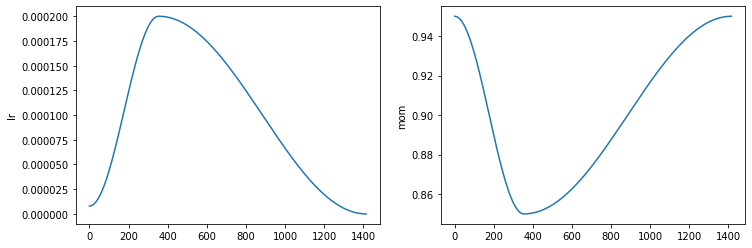

In [ ]:
learn.recorder.plot_sched()

In [ ]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,1.322788,0.317486,0.004964,0.004964,36:16
1,0.223381,0.004076,0.002363,0.002363,36:13


In [ ]:
learn.save('Comb_4')

Path('weights/Comb_4.pth')

In [ ]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.125142,0.052664,0.003794,0.003794,40:49
1,0.037557,0.002450,0.002057,0.002057,39:27


In [ ]:
learn.save('Comb_6')

Path('weights/Comb_6.pth')

In [ ]:
learn.fit_flat_cos(2, lr=2e-04, pct_start=0)

epoch,train_loss,valid_loss,valid_leaderboard,valid_leaderboard2,time
0,0.064689,0.022935,0.001123,0.001123,40:20
1,0.022693,0.002279,0.001968,0.001968,43:00


In [ ]:
learn.save('Comb_8')

Path('weights/Comb_8.pth')

## Testing

In [7]:
learn.load('model_80')

/home/featurize/work/.local/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [8]:
x, y = test_dl.one_batch()
preds = learn.model(x)

In [42]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
pred_idx = 3
pred = preds[0][pred_idx].cpu().detach().numpy()
print(pred.shape)

(8, 256, 256)


In [43]:
label = y[pred_idx].cpu().detach().numpy()
print(label.shape)

(8, 256, 256)


In [44]:
input = x[0].cpu().detach().numpy()

In [45]:
pred = recover(pred, 17., 32.)
label = recover(label, 17., 32.)
input = recover(input, 17., 32.)

In [46]:
print(pred[:,0,0])
print(label[:,0,0])

[21.807772 21.919096 22.38925  22.422699 21.851404 22.555756 21.952276
 22.071789]
[22.76   22.915  22.535  22.645  22.49   22.95   22.6525 22.7275]


In [47]:
diff = abs(pred - label)
print(diff)

[[[0.95222855 0.08881569 0.58564186 ... 0.24144363 0.13755989 0.68590546]
  [0.29891586 0.1205101  0.43255806 ... 0.00302124 0.10110092 0.20577812]
  [0.10599899 0.23417473 0.2367897  ... 0.03835678 0.11480331 0.2545452 ]
  ...
  [0.04089928 1.639307   0.8318882  ... 0.4279518  0.39435577 1.046051  ]
  [0.10215759 1.384737   0.8278389  ... 0.40437698 0.39050293 1.3785439 ]
  [0.89928436 1.6098003  1.3619156  ... 0.9547558  1.2080784  1.7310791 ]]

 [[0.9959049  0.02574348 0.38313866 ... 0.3509884  0.27122307 0.01557541]
  [0.7118397  0.76496315 0.31409645 ... 0.41846085 0.5998783  0.36057281]
  [0.7733002  0.8692379  0.33349037 ... 0.20918465 0.29356956 0.43710327]
  ...
  [1.9175148  1.8385582  1.1109104  ... 0.6401844  0.63191414 0.22260857]
  [2.2118912  1.4219894  0.8568649  ... 0.5162945  0.24927902 0.05443954]
  [2.8264675  1.7247715  1.1792545  ... 0.6452427  0.76732063 1.1870136 ]]

 [[0.14575005 0.06207085 0.30501938 ... 0.0160408  0.15953445 0.60074806]
  [0.08071136 0.108627

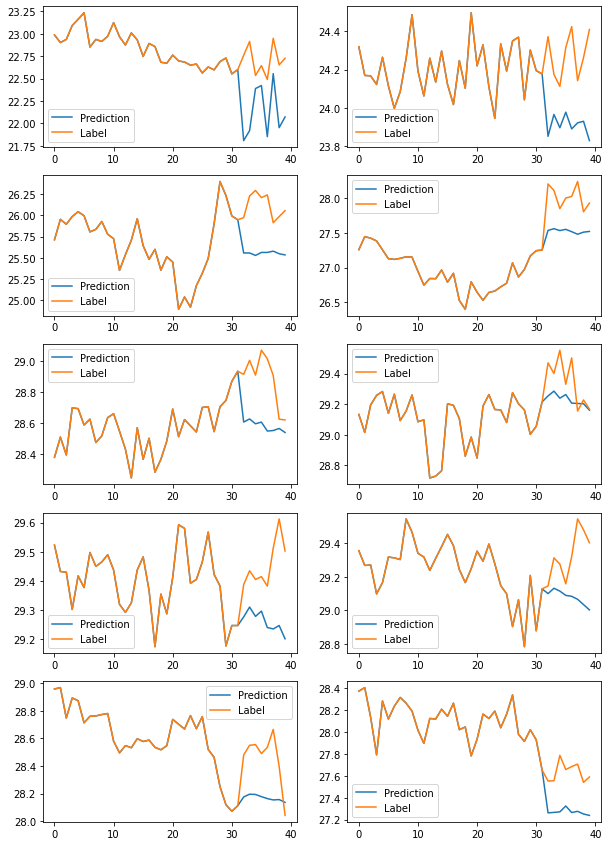

In [48]:
# idx = [100, 250]
plt.figure(figsize=(10,15))
for idx in range(10):
    i = idx*15
    plt.subplot(5,2,idx+1)
    plt.plot(concat(input[...,i, i], pred[...,i, i]))
    plt.plot(concat(input[...,i, i],label[...,i, i]))
    plt.legend(['Prediction', 'Label'])

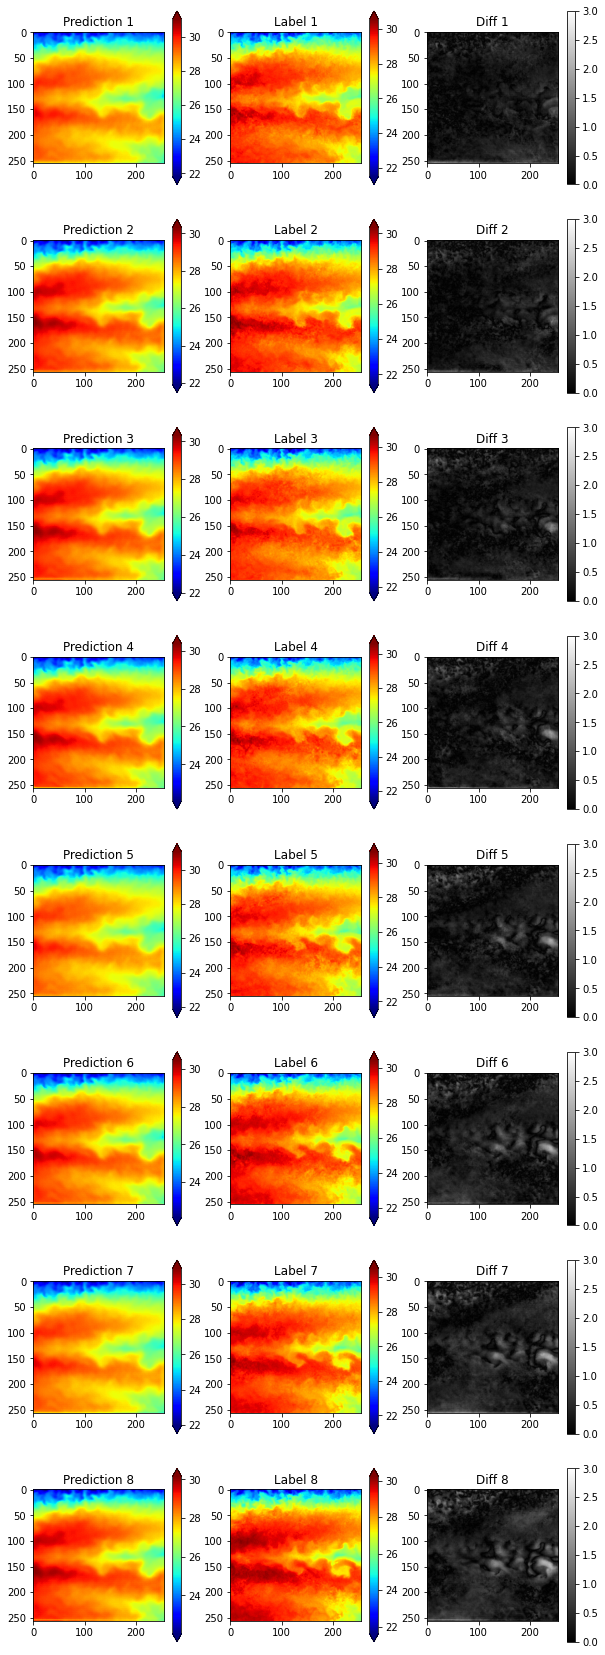

In [49]:
plt.figure(figsize=(10,30))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet')
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet')
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray', vmin=0, vmax=3)
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
